# Tech Layoffs Analysis in the US

Over the past few years, the tech industry has experienced explosive growth, driven by high
valuations, significant venture capital inflows, and a bull market that fueled aggressive
expansion strategies. Many startups and even established companies pursued a “growth at all
costs” mentality, rapidly scaling their workforce to meet inflated investor expectations. However,
as the economic environment shifts, with interest rates rising and investor sentiment cooling,
many of these companies are finding themselves overextended. This project aims to uncover
insights into the tech industry’s current challenges. Through this analysis, we hope to provide a
clearer understanding of how economic forces and internal business decisions are reshaping
the sector.


## Reading in the dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import os

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, BORDERS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
layoff_df = pd.read_csv("./layoffs.csv")
layoff_df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Freshworks,SF Bay Area,Support,660.0,0.13,2024-11-07,Post-IPO,United States,484.0
1,Opendoor,SF Bay Area,Real Estate,300.0,0.17,2024-11-07,Post-IPO,United States,1900.0
2,Personio,Munich,HR,115.0,0.06,2024-11-07,Series E,Germany,724.0
3,iRobot,Boston,Consumer,105.0,0.16,2024-11-06,Post-IPO,United States,30.0
4,Outreach,Seattle,Sales,67.0,0.09,2024-11-06,Series G,United States,489.0


Our analysis focuses on layoffs in the US therefore, we will go ahead and filter out international companies.

In [4]:
layoff_us = layoff_df[layoff_df['country']=='United States']

## Dataset cleaning

In [5]:
# Check for missing values
layoff_us.isnull().sum()

company                  0
location                 1
industry                 1
total_laid_off         918
percentage_laid_off    887
date                     0
stage                    4
country                  0
funds_raised           225
dtype: int64

Given the significant number of missing values, it is not possible to accurately impute the values. Since the dataset pertains to layoffs, we can reasonably assume that at least one employee was laid off, making it inappropriate to replace the missing values with zeros. Therefore, we resort to dropping the missing values.

In [6]:
# Our main focus is on the total_laid_off column, so we will drop the rows where the total_laid_off column is null
layoff_us = layoff_us.dropna(subset=['total_laid_off'])
layoff_us.isnull().sum()

company                  0
location                 0
industry                 1
total_laid_off           0
percentage_laid_off    449
date                     0
stage                    2
country                  0
funds_raised           126
dtype: int64

We also check for duplicates.

In [7]:
# Check for duplicates
duplicates = layoff_us.duplicated()
duplicates.sum()

# Drop duplicates
layoff_us = layoff_us.drop_duplicates()
duplicates = layoff_us.duplicated()
duplicates.sum()

0

In [8]:
layoff_us.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1588 entries, 0 to 3860
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1588 non-null   object 
 1   location             1588 non-null   object 
 2   industry             1587 non-null   object 
 3   total_laid_off       1588 non-null   float64
 4   percentage_laid_off  1139 non-null   float64
 5   date                 1588 non-null   object 
 6   stage                1586 non-null   object 
 7   country              1588 non-null   object 
 8   funds_raised         1462 non-null   float64
dtypes: float64(3), object(6)
memory usage: 124.1+ KB


In [9]:
# Convert the 'date' column to datetime format
layoff_us['date'] = pd.to_datetime(layoff_us['date'])

## Data Exploration

### Trend Analysis

The data spans from 2020 to 2024 and we aim to investigate the trend of layoffs overtime.

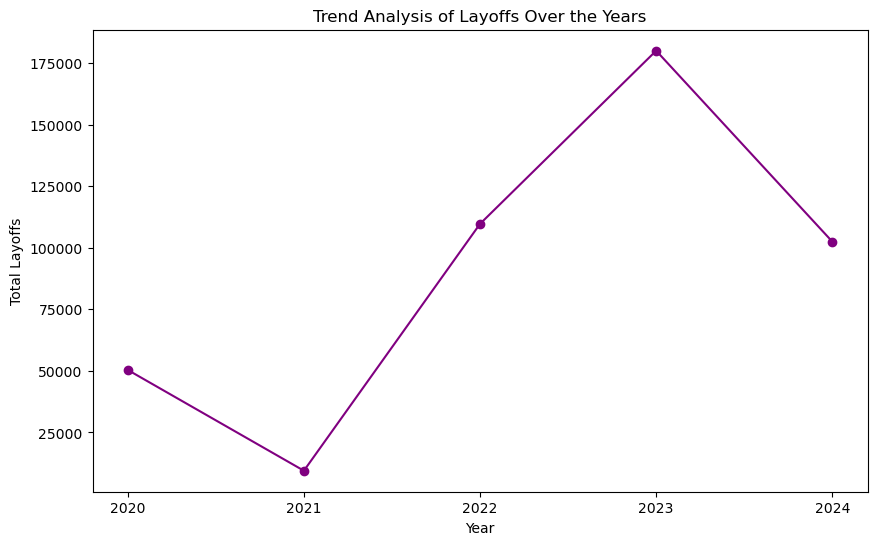

In [10]:
# Extract the year from the 'date' column
layoff_us['year'] = layoff_us['date'].dt.year

# Group by year and sum the total layoffs
layoffs_by_year = layoff_us.groupby('year')['total_laid_off'].sum()

# Plot the trend
plt.figure(figsize=(10, 6))
plt.plot(layoffs_by_year.index, layoffs_by_year.values, marker='o', linestyle='-', color='purple')
plt.title('Trend Analysis of Layoffs Over the Years')
plt.xticks(ticks=np.arange(2020, 2025, 1))
plt.xlabel('Year')
plt.ylabel('Total Layoffs')
plt.show()

**2020:** Tech companies experienced a boom as they expanded to meet demand as remote work, e-commerce, and digital services surged.  
**2021-2022:** Macroeconomic pressures, including rising interest rates, inflation, and fears of a global recession, forced companies to cut costs. Moreover, many firms found themselves overstaffed relative to slower-than-expected growth as they had anticipated sustained demand for digital services, which later normalized.  
**2023:** Layoffs peaked as even major tech players reduced their workforces to streamline operations and focus on profitability.

#### Do layoffs surge during certain quarters?

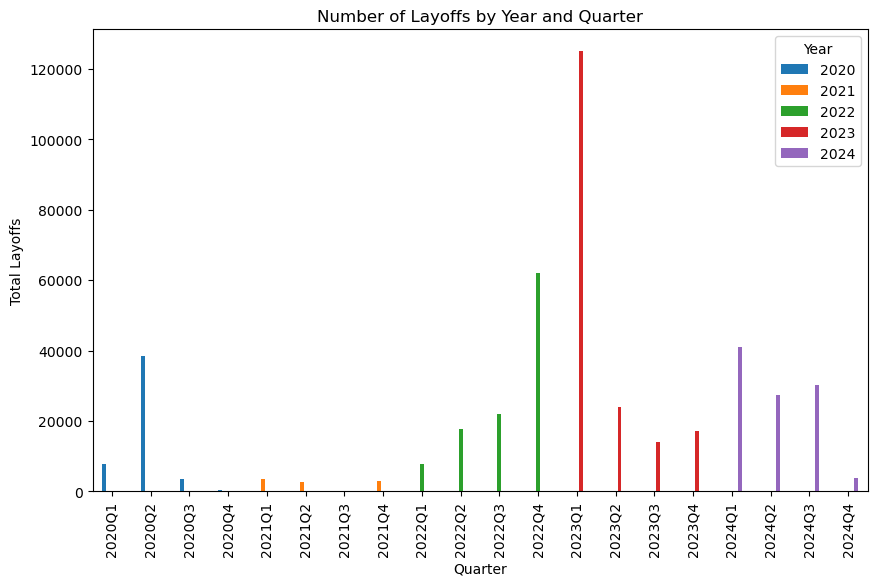

In [11]:
# Extract the quarter from the 'date' column
layoff_us['quarter'] = layoff_us['date'].dt.to_period('Q')

# Group by year and quarter and sum the total layoffs
layoffs_by_quarter = layoff_us.groupby(['year', 'quarter'])['total_laid_off'].sum().reset_index()

# Pivot the data to have years as columns and quarters as rows
layoffs_by_quarter_pivot = layoffs_by_quarter.pivot(index='quarter', columns='year', values='total_laid_off')

# Plot the data
layoffs_by_quarter_pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Layoffs by Year and Quarter')
plt.xlabel('Quarter')
plt.ylabel('Total Layoffs')
plt.legend(title='Year')
plt.show()

 - Q1 appears to be the most consistently affected by layoffs. It is critical period for organizations to recalibrate their operations.    
 - It is when companies do annual budget reviews and implement major structural changes, including workforce reductions, to align with strategic goals for the year.


### Geographical distribution

Which cities have been hit the hardest?

In [12]:
layoff_us['location'].value_counts().head(15)

location
SF Bay Area        640
New York City      249
Boston             103
Seattle             93
Los Angeles         86
Austin              39
Chicago             38
San Diego           26
Denver              20
Washington D.C.     18
Salt Lake City      18
Portland            16
Atlanta             16
Columbus            13
Miami               13
Name: count, dtype: int64

It will be great if we can visualize this summary on the US map.  
Since our dataset does not have coordinates we will read in a csv with US cities coords and do a merge. 

In [13]:
city_coords = pd.read_csv("./us2021census.csv")
city_coords.head()

,City,State,Type,Counties,Population,Latitude,Longitude
0,New York,NY,City,Bronx;Richmond;New York;Kings;Queens,8804190,40.714,-74.007
1,Los Angeles,CA,City,Los Angeles,3898747,34.052,-118.243
2,Chicago,IL,City,Cook;DuPage,2746388,41.882,-87.628
3,Houston,TX,City,Harris;Fort Bend;Montgomery,2304580,29.760,-95.363
4,Phoenix,AZ,City,Maricopa,1608139,33.448,-112.074


In [14]:
city_coords[city_coords['City'] == 'Boston']

,City,State,Type,Counties,Population,Latitude,Longitude
23,Boston,MA,City,Suffolk,675647,42.359,-71.057
10929,Boston,GA,City,Thomas,1207,30.791,-83.789
19137,Boston,IN,Town,Wayne,150,39.741,-84.852


- Looking at the census data we realize that some states share similar city names e.g we have Boston in (MA,GA and IN). 
- To make sure we match the company and the right coordinates, we will make a function to give a list of companies in a city then do a google search to confirm if it matches the city and state.

In [15]:
def search_companies(city_name, dataframe):
  """
  Parameters:
  city_name (str): The name of the city to search for.
  dataframe (pd.DataFrame): The dataframe containing the layoff data.

  Returns:
  list: A list of companies in the specified city.
  """
  companies = dataframe[dataframe['location'] == city_name]['company'].tolist()
  return companies


In [ ]:
# We will look up the companies in each city then use ChatGPT to confirm if they are all in that specific city and state.
city_name = 'Atlanta'
companies_in_city = search_companies(city_name, layoff_us)
print(companies_in_city)

['Cypress.io', 'Bakkt', 'FullStory', 'SecureWorks', 'Calendly', 'SecureWorks', 'Salesloft', 'Greenlight', 'Cardlytics', 'Sunday', 'OneTrust', 'Stord', 'Wahoo Fitness', 'Vesta', 'SalesLoft', 'OneTrust']


We find that all these companies are in the top cities. Let's create a dictionary with the state and city for correct matching of coordinates.

In [17]:
# Define specific locations in certain states with state abbreviations
specific_locations = {
    'CA': ['SF Bay Area', 'Los Angeles', 'San Diego'],
    'NY': ['New York City'],
    'MA': ['Boston'],
    'WA': ['Seattle'],
    'TX': ['Austin'],
    'IL': ['Chicago'],
    'CO': ['Denver'],
    'DC': ['Washington D.C.'],
    'UT': ['Salt Lake City'],
    'OR': ['Portland'],
    'GA': ['Atlanta'],
    'OH': ['Columbus'],
    'FL': ['Miami']
}
# Filter city_coords to include only the specific locations
top_cities = city_coords[city_coords.apply(lambda row: row['City'] in specific_locations.get(row['State'], []), axis=1)]
top_cities['City'].unique()
top_cities.head()

,City,State,Type,Counties,Population,Latitude,Longitude
1,Los Angeles,CA,City,Los Angeles,3898747,34.052,-118.243
2,Chicago,IL,City,Cook;DuPage,2746388,41.882,-87.628
7,San Diego,CA,City,San Diego,1386932,32.716,-117.165
10,Austin,TX,City,Williamson;Travis;Hays,961855,30.268,-97.743
13,Columbus,OH,City,Delaware;Franklin;Fairfield,905748,39.962,-83.001


Some cities did not match. We know that SF Bay Area is a collection of cities (San Francisco, Oakland and San Jose).   
New York and Washington are splet differently in the two datasets.

In [18]:
# Replace the specified location names in the city_coords dataframe
city_coords['City'] = city_coords['City'].replace({
    'New York': 'New York City',
    'Washington': 'Washington D.C.'
})

In [19]:
top_cities = city_coords[city_coords.apply(lambda row: row['City'] in specific_locations.get(row['State'], []), axis=1)]
top_cities.head()

,City,State,Type,Counties,Population,Latitude,Longitude
0,New York City,NY,City,Bronx;Richmond;New York;Kings;Queens,8804190,40.714,-74.007
1,Los Angeles,CA,City,Los Angeles,3898747,34.052,-118.243
2,Chicago,IL,City,Cook;DuPage,2746388,41.882,-87.628
7,San Diego,CA,City,San Diego,1386932,32.716,-117.165
10,Austin,TX,City,Williamson;Travis;Hays,961855,30.268,-97.743


New York and Washington D.C. are now added. We will do a merge then add the SF Bay Area coords.

In [20]:
# Merge layoff_us with top_cities based on location and City columns
layoff_city_coords = layoff_us.merge(top_cities, left_on='location', right_on='City', how='left')
layoff_city_coords.tail()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year,quarter,City,State,Type,Counties,Population,Latitude,Longitude
1583,Help.com,Austin,Support,16.0,1.00,2020-03-16,Seed,United States,6.0,2020,2020Q1,Austin,TX,City,Williamson;Travis;Hays,961855.0,30.268,-97.743
1584,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,Unknown,United States,45.0,2020,2020Q1,Los Angeles,CA,City,Los Angeles,3898747.0,34.052,-118.243
1585,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,Seed,United States,1.0,2020,2020Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1586,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,Series C,United States,90.0,2020,2020Q1,Los Angeles,CA,City,Los Angeles,3898747.0,34.052,-118.243
1587,EasyPost,Salt Lake City,Logistics,75.0,NaN,2020-03-11,Series A,United States,12.0,2020,2020Q1,Salt Lake City,UT,City,Salt Lake,199723.0,40.769,-111.891


In [21]:
# Define the new coordinates
new_coords = {
    'SF Bay Area': (37.8272, -122.2913),
}

# Update the coordinates in the dataframe
for location, (lat, lon) in new_coords.items():
    layoff_city_coords.loc[layoff_city_coords['location'] == location, ['Latitude', 'Longitude']] = lat, lon

# Verify the changes
#layoff_city_coords[layoff_city_coords['location'].isin(new_coords.keys())]
layoff_city_coords.tail()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year,quarter,City,State,Type,Counties,Population,Latitude,Longitude
1583,Help.com,Austin,Support,16.0,1.00,2020-03-16,Seed,United States,6.0,2020,2020Q1,Austin,TX,City,Williamson;Travis;Hays,961855.0,30.2680,-97.7430
1584,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,Unknown,United States,45.0,2020,2020Q1,Los Angeles,CA,City,Los Angeles,3898747.0,34.0520,-118.2430
1585,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,Seed,United States,1.0,2020,2020Q1,NaN,NaN,NaN,NaN,NaN,37.8272,-122.2913
1586,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,Series C,United States,90.0,2020,2020Q1,Los Angeles,CA,City,Los Angeles,3898747.0,34.0520,-118.2430
1587,EasyPost,Salt Lake City,Logistics,75.0,NaN,2020-03-11,Series A,United States,12.0,2020,2020Q1,Salt Lake City,UT,City,Salt Lake,199723.0,40.7690,-111.8910


We now have the coordinates in place. Let's now look at the geographical distribution.

#### Extracting the data for plotting

In [22]:
# Filter out rows with missing or infinite coordinate values
layoff_city_coords = layoff_city_coords.dropna(subset=['Latitude', 'Longitude'])
layoff_city_coords = layoff_city_coords[np.isfinite(layoff_city_coords['Latitude'])]
layoff_city_coords = layoff_city_coords[np.isfinite(layoff_city_coords['Longitude'])]

# Extract the relevant data for plotting
lat = layoff_city_coords['Latitude'].values
lon = layoff_city_coords['Longitude'].values
# color to reflect number of layoffs
laidoff = layoff_city_coords.groupby('location')['total_laid_off'].transform('sum').values
# and size to reflect number of companies in the location
total_companies = layoff_city_coords.groupby('location')['company'].transform('count').values

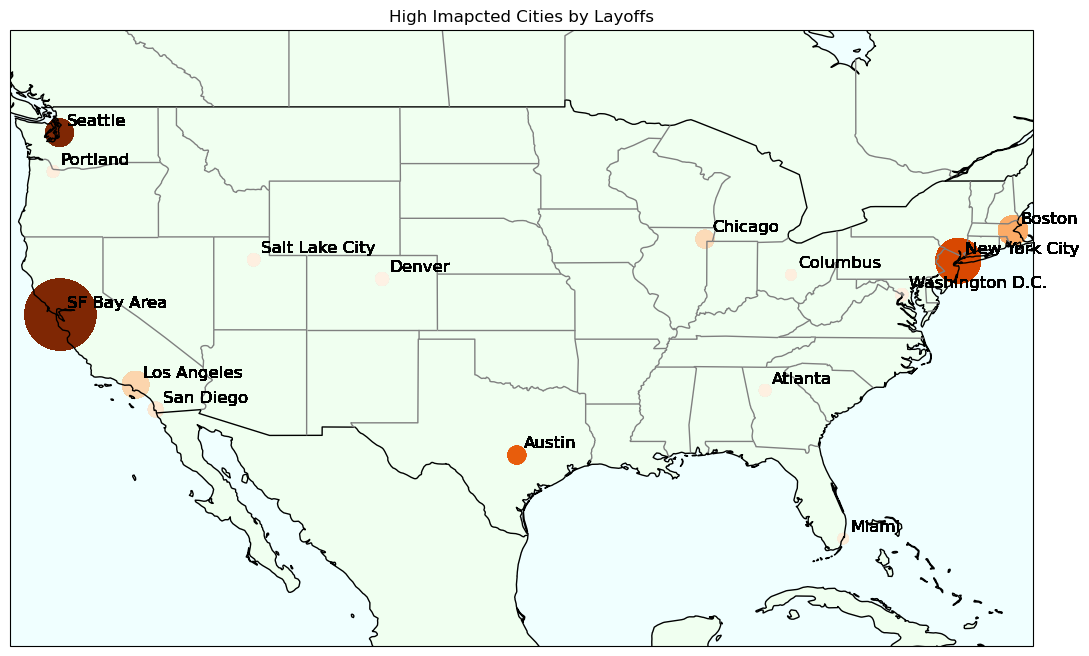

In [61]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([-125,-70,20,50])
# display land and coastline
ax.add_feature(LAND, facecolor="honeydew")
ax.add_feature(COASTLINE)
ax.add_feature(BORDERS)
ax.set_facecolor('azure')
# display states
states = NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states, edgecolor='gray')

im = ax.scatter(lon, lat, 
          s=total_companies*4, c=laidoff,   # Adjust the size for better visualization
          cmap='Oranges', vmin=100, vmax=50000, alpha=0.5)
# Annotate city names
for i, row in layoff_city_coords.iterrows():
        ax.annotate(row['location'], xy=(row['Longitude'], row['Latitude']), xytext=(5, 5), textcoords='offset points', fontsize=12, color='black')
# create colorbar
#plt.colorbar(im,label= 'layoff magnitude')
plt.title('High Imapcted Cities by Layoffs');


- Tech industry is concentrated in major hubs like San Francisco Bay Area, Seattle, New York City and Boston, which are known for their dense networks of tech companies. 
- These hubs experience the largest impacts during layoffs.

Below are the leading companies with the highest number of layoffs.

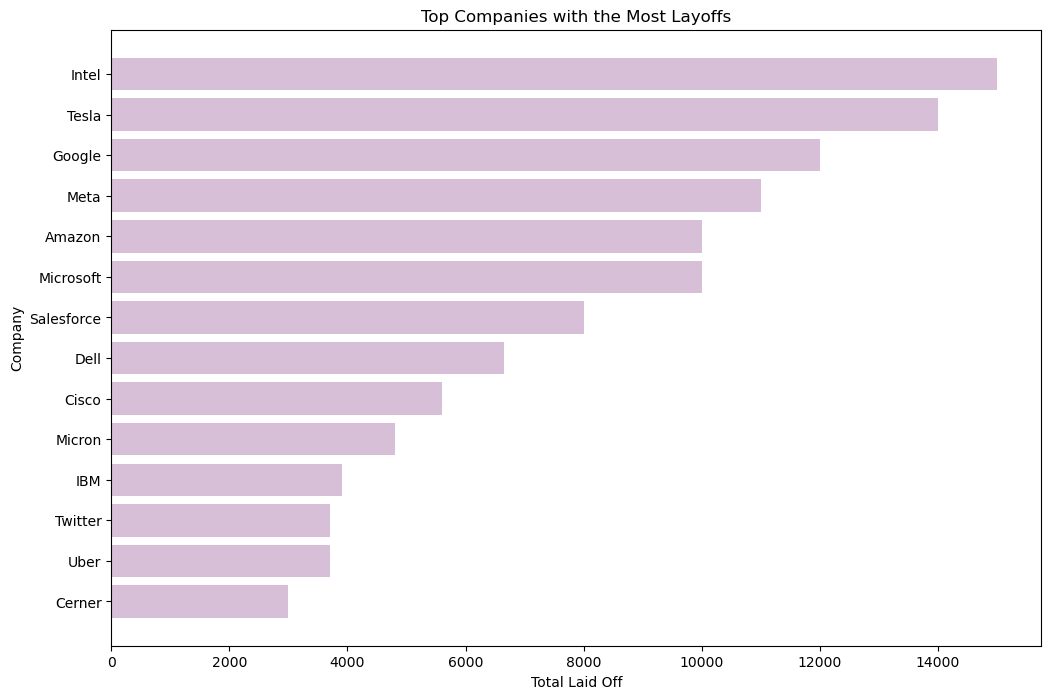

In [56]:
# Sort the top_companies dataframe by total_laid_off in descending order and select the top 20 companies
top_companies = layoff_us.sort_values(by='total_laid_off', ascending=False).head(20)

# Create a bar graph
plt.figure(figsize=(12, 8))
plt.barh(top_companies['company'], top_companies['total_laid_off'], color='thistle')
plt.xlabel('Total Laid Off')
plt.ylabel('Company')
plt.title('Top Companies with the Most Layoffs')
plt.gca().invert_yaxis()  # Invert y-axis to have the company with the most layoffs at the top
plt.show()

We see that companies with the highest layoffs are well-established public companies.  


Let's analyze the companies in the dataset to understand how different funding stages—early, growth, and late—were affected by layoffs.

In [71]:
# number of people laidoff at every funding stage
laidoff_count = layoff_us.groupby('stage')['total_laid_off'].sum().sort_values(ascending=False)
laidoff_count

stage
Post-IPO          307898.0
Acquired           39510.0
Unknown            29081.0
Series D           14695.0
Series C           13017.0
Series E           11487.0
Series B           11309.0
Series F            8300.0
Series H            5447.0
Private Equity      3795.0
Series A            2960.0
Subsidiary          1819.0
Series G            1802.0
Seed                 439.0
Series I             195.0
Name: total_laid_off, dtype: float64

##### Below we'll write a function to plot a horizontal bar for the stage layoff and later reuse it to plot industry layoff

In [26]:
# Sort values in descending order
def plot_horizontal_bar(data, title, xlabel, ylabel, color='thistle'):
    """
    Plots a horizontal bar chart with percentage labels.

    Parameters:
    data (pd.Series): The data to plot, with the index as the labels and values as the bar lengths.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    color (str): The color of the bars (default is 'thistle').
    """
    # Calculate percentages
    data_pct = (data / data.sum()) * 100

    # Create horizontal bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.barh(y=data.index, width=data_pct, color=color)

    # Add percentage labels
    for i, v in enumerate(data_pct):
        plt.text(v + 0.5, i, f'{v:.1f}%', va='center')

    # Customize the plot
    plt.title(title, pad=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add gridlines for better readability
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


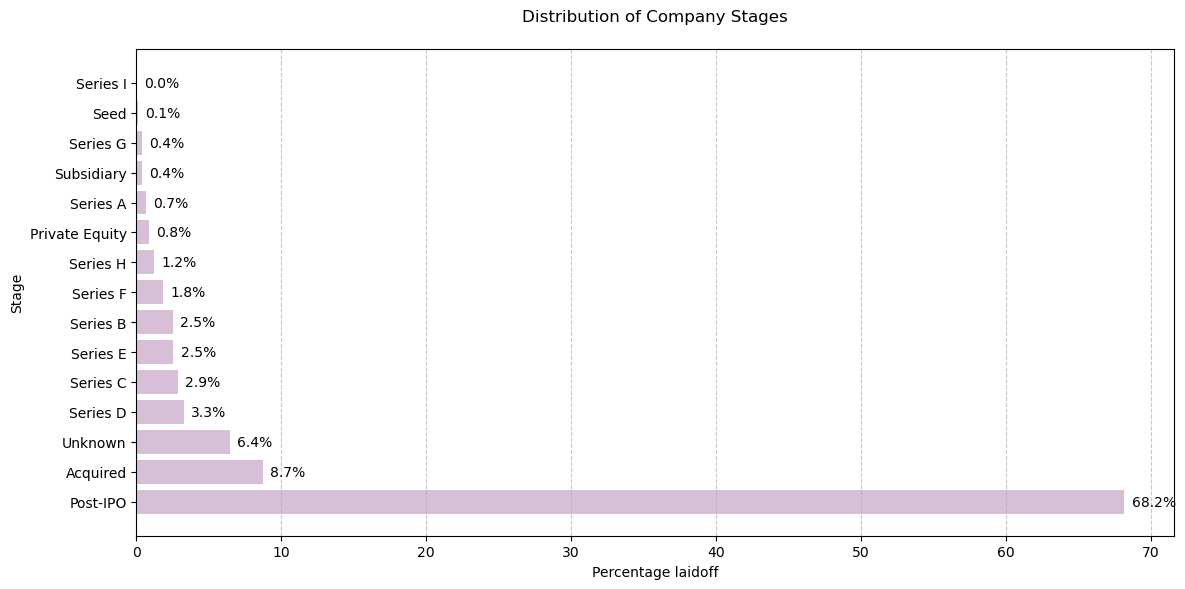

In [69]:
# layoffs by company stages
stage_layoffs = layoff_us.groupby('stage')['total_laid_off'].sum().sort_values(ascending=False)
plot_horizontal_bar(stage_layoffs, 'Distribution of Company Stages', 'Percentage laidoff', 'Stage')

From the distribution of company stages, it is evident that Post-IPO companies account for the highest percentage of layoffs. This aligns with expectations, as later-stage companies and publicly traded firms generally have larger workforces and are more likely to conduct mass layoffs during economic downturns to optimize costs.   

**Disclaimer:** Larger companies naturally have bigger workforces, which inflates the absolute number of layoffs compared to smaller or earlier-stage firms. To draw more accurate conclusions about which stages are most affected, we would need the total number of employees at each company stage. This would allow us to calculate the percentage of employees laid off and provide a fair comparison across company stages. Without this information, the observed trends primarily reflect absolute layoff numbers rather than proportional impact.

#### In the dataset we also see some companies that laidoff all the employees

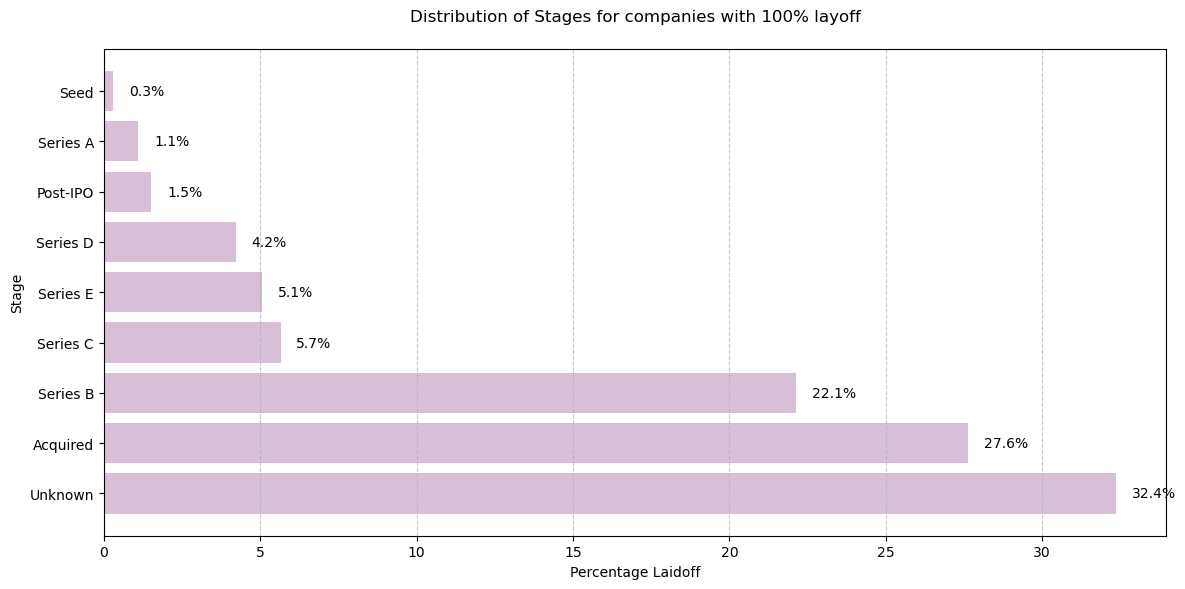

In [ ]:
all_laidoff = layoff_us[layoff_us['percentage_laid_off'] == 1]
all_laidoff_count = all_laidoff.groupby('stage')['total_laid_off'].sum().sort_values(ascending=False)
plot_horizontal_bar(all_laidoff_count, 'Distribution of Stages for companies with 100% layoff', 'Percentage Laidoff', 'Stage')

In [60]:
all_laidoff_count = all_laidoff.groupby('stage')['total_laid_off'].sum().sort_values(ascending=False)
all_laidoff_count

stage
Unknown     3826.0
Acquired    3268.0
Series B    2617.0
Series C     669.0
Series E     600.0
Series D     500.0
Post-IPO     180.0
Series A     131.0
Seed          35.0
Name: total_laid_off, dtype: float64

#### Is there a correlation between the amount of funding raised and the likelihood or size of layoffs?

Correlation between funds raised and total laid off by company: 0.17148206331996177


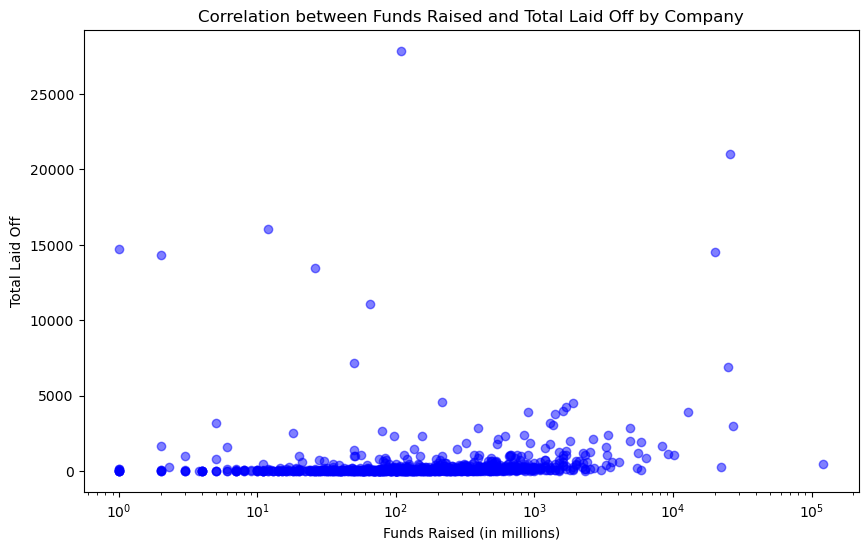

In [ ]:
# Group the data by company and sum the total laid off
# coz of the grouping we do a mean for funds because it's a repetition when the company has multiple layoffs 
company_grouped = layoff_us.groupby('company').agg({'total_laid_off': 'sum', 'funds_raised': 'mean'}) 
# Calculate the correlation
correlation = company_grouped['funds_raised'].corr(company_grouped['total_laid_off'])
print(f"Correlation between funds raised and total laid off by company: {correlation}")

# Plot the correlation
plt.figure(figsize=(10, 6))
plt.scatter(company_grouped['funds_raised'], company_grouped['total_laid_off'], alpha=0.5, c='b')
plt.xticks([1000, 10000, 100000],['1k', '10k', '100k'])
plt.title('Correlation between Funds Raised and Total Laid Off by Company')
plt.xlabel('Funds Raised (in millions)')
plt.ylabel('Total Laid Off')
plt.xscale('log')
plt.show()

- Our analysis reveals no significant correlation between the amount of funds raised and the size of layoffs.  
- This suggests that high fundraising may create a false sense of security, leading companies to overexpand their operations or hire aggressively, only to face downsizing when market conditions shift.
- Despite having substantial resources, these companies are not immune to economic pressures or the need to restructure.

Next, let's identify which sectors within the tech industry were most affected.

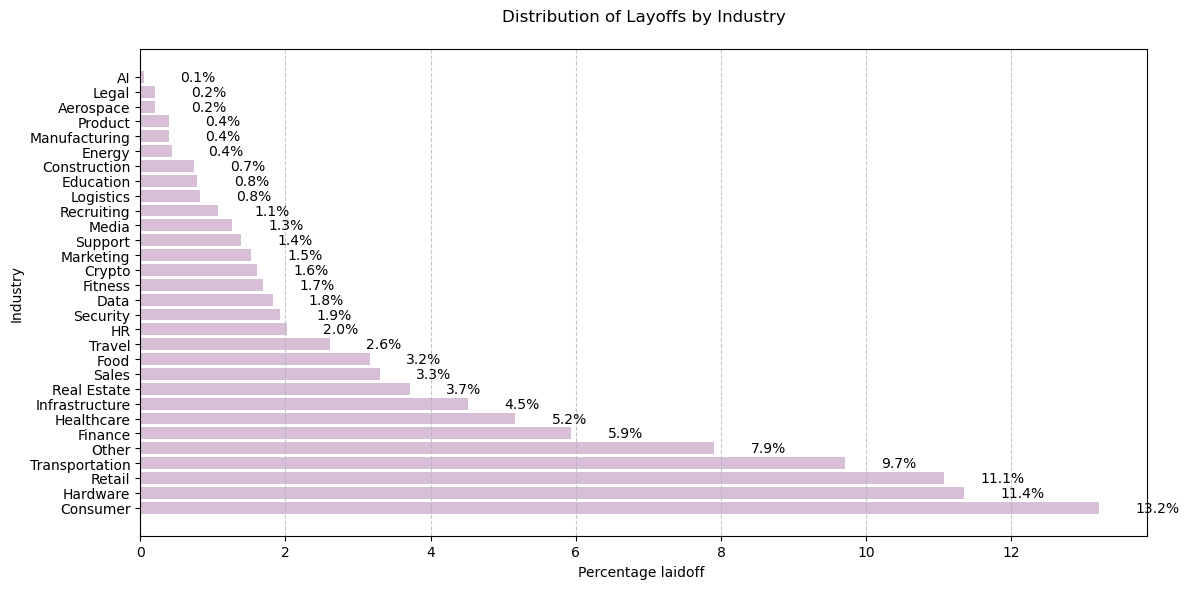

In [68]:
industry_layoffs = layoff_us.groupby('industry')['total_laid_off'].sum().sort_values(ascending=False)
plot_horizontal_bar(industry_layoffs, 'Distribution of Layoffs by Industry', 'Percentage laidoff ', 'Industry')

- AI companies were less affected during the tech layoffs primarily because AI adoption surged across industries, making their technologies highly valuable and essential.
- Infact many AI companies experienced robust revenue growth or secured significant funding due to the optimism surrounding AI's transformative potential.